# Import libs

In [1]:
# Common libs
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Layer, Input, BatchNormalization, Dropout, Activation
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
from tensorflow.keras.regularizers import l1, l2

print('Import succesfully')

Import succesfully


In [2]:
# Defining the seed for some random operations:
random_seed = 42

# Setting some variables to format the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

# Prepare dataset

Download mnist dataset. The dataset contains 60,000 images for the training and 10,000 images for the testing. Then normalize the images from range [0, 255] to [0, 1] and resize to 28 x 28 x 1.

In [3]:
num_classes = 10
img_rows, img_cols, img_channels = 28, 28, 1
input_shape = (img_rows, img_cols, img_channels)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)

To highlights the advantages of regularization, we will reduce the number of samples available for training

In [5]:
# Get 200 samples from train set instead of 60000
X_train, y_train = X_train[:200], y_train[:200] 

print('Training set: ', X_train.shape)
print('Test set: ', X_test.shape)

Training set:  (200, 28, 28, 1)
Test set:  (10000, 28, 28, 1)


# Manually define Convolution layer and Regularization

## Define simple Conv layer without Regularization

In [6]:
@tf.function
def conv_layer(inputs, kernels, bias, stride):
  x = tf.nn.conv2d(inputs, kernels, strides=[1, stride, stride, 1], padding='VALID')
  # Applying the bias and activation function
  return tf.nn.relu(x + bias)

class SimpleConvolutionLayer(Layer):
  def __init__(self, num_kernels=32, kernel_size=(3, 3), stride=1):
    """Initialize the layer.
    :param num_kernels: Number of kernels.
    :param kernel_size: Kernel size (H x W).
    :param stride: stride.
    """

    super().__init__()
    self.num_kernels = num_kernels
    self.kernel_size = kernel_size
    self.stride = stride

  def build(self, input_shape):
    """Build the layer, initializing its parameters.
    This will be internally called the 1st time the layer is used.
    :param input_shape: Input shape for the layer (e.g. B x H x W x D).
    """

    num_channels = input_shape[-1]
    # Set the shape of kernel (e.g. H x W x D x N).
    kernel_shape = (*self.kernel_size, num_channels, self.num_kernels)  
    # Initialize the filter values e.g. from Glorot distributions:
    glorot_init = tf.initializers.GlorotUniform()
    # Initialize kernel and its weights.
    self.kernels = self.add_weight(name='kernel', shape=kernel_shape, 
                                   initializer=glorot_init, trainable=True)
    # Initialize bias from a normal distribution.
    self.bias = self.add_weight(name='bias', shape=(self.num_kernels, ), 
                                initializer='random_normal', trainable=True)
    
  def call(self, inputs):
    """Call the layer, apply its operations to the input tensor.
    :param inputs: batch of inputs.
    """
    
    return conv_layer(inputs, self.kernels, self.bias, self.stride)

We will extend this layer class to add kernel/bias regularization.

In [7]:
from functools import partial

def l2_reg(coef=1e-2):
  """Return a function computing a weighted L2 norm of a given tensor.
  :param coef: Weight for the norm.
  :return: loss function
  """

  return lambda x: tf.reduce_sum(x ** 2) * coef

class ConvWithRegularizers(SimpleConvolutionLayer):
  def __init__(self, num_kernels=32, kernel_size=(3, 3), stride=1, 
               kernel_regularizer=l2_reg(), bias_regularizer=l2_reg()):
    """Initializer the layer.
    :param num_kernels: Number of kernels.
    :param kernel_size: Kernel size (H x W).
    :param stride: stride.
    :param kernel_regularizer: (opt.) Regularization loss for the kernel.
    :param bias_regularizer: (opt.) Regularization loss for the bias.
    """

    super().__init__(num_kernels, kernel_size, stride)
    self.kernel_regularizer=kernel_regularizer
    self.bias_regularizer=bias_regularizer

  def build(self, input_shape):
    """Build the layer, initialize its component.
    :param input_shape: Input shape for the layer (B x H x W x D).
    """

    super().build(input_shape)
    # Attaching the regularization losses to the variables.
    if self.kernel_regularizer is not None:
      self.add_loss(partial(self.kernel_regularizer, self.kernels))
    if self.bias_regularizer is not None:
      self.add_loss(partial(self.bias_regularizer, self.bias))

When instantiating this layer, the regularizer passed as attributes will be attached to the layer. The loss values of these regularizers can be obtained whenever, simply calling the layer's property `.losses`.

In [8]:
conv = ConvWithRegularizers(num_kernels=32, kernel_size=(3, 3), stride=1,
                            kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.))
conv.build(input_shape=tf.TensorShape((None, *X_train[0].shape)))

# Fetching the layer' losses:
reg_losses = conv.losses
print('Regularization losses over kernel and bias parameter: {}'.format(
    [loss.numpy() for loss in reg_losses]
))

# Comparing with the L2 norms of its kernels and bias tensors:
kernel_norm, bias_norm = tf.reduce_sum(conv.kernels ** 2).numpy(), tf.reduce_sum(conv.bias ** 2).numpy()
print('L2 norms of kernel and bias parameters: {}'.format([kernel_norm, bias_norm]))

Regularization losses over kernel and bias parameter: [1.8983475, 0.11072562]
L2 norms of kernel and bias parameters: [1.8983475, 0.11072562]


The property `losses` also lists all the losses attached to all the layers and models composing an instance.

In [9]:
# Creating model
model = Sequential([Input(shape=tf.TensorShape((None, *input_shape))),
                    ConvWithRegularizers(kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.)),
                    ConvWithRegularizers(kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.)),
                    ConvWithRegularizers(kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.))])

print('Losses attached to the model and its layers:\n\r{} ({} losses)'.format(
    [loss.numpy() for loss in model.losses], len(model.losses)
))

Losses attached to the model and its layers:
[2.0931308, 0.07003205, 31.58438, 0.10536526, 31.724579, 0.08345811] (6 losses)


Building LeNet5 with out custom conv layer, and train it taking into account the regularization term.

In [10]:
class LeNet5(Model):

  def __init__(self, num_classes, 
               kernel_regularizer=l2_reg(), 
               bias_regularizer=l2_reg()):
    """Initialize the model.
    :param num_classes: number of classes.
    :param kernel_regularizer: (opt.) regularizaton for kernels.
    :param bias_regularizer: (opt.) regularization for biass.
    """

    super(LeNet5, self).__init__()
    self.num_classes = num_classes
    self.conv1 = ConvWithRegularizers(num_kernels=6, kernel_size=(5, 5),
                                      kernel_regularizer=kernel_regularizer,
                                      bias_regularizer=bias_regularizer)
    self.conv2 = ConvWithRegularizers(num_kernels=16, kernel_size=(5, 5),
                                      kernel_regularizer=kernel_regularizer,
                                      bias_regularizer=bias_regularizer)
    self.max_pool = MaxPooling2D(pool_size=(2, 2))
    self.flatten = Flatten()
    self.dense1 = Dense(120, activation='relu')
    self.dense2 = Dense(84, activation='relu')
    self.dense3 = Dense(num_classes, activation='sigmoid')

  def call(self, inputs):
    """Run the operation of the layers in order to process the input.
    :params inputs: input tensor (B x H x W x D).
    :return outputs: ouput tensor.
    """

    outputs = self.max_pool(self.conv1(inputs))  # conv1
    outputs = self.max_pool(self.conv2(outputs))  # conv2
    outputs = self.flatten(outputs)
    outputs = self.dense3(self.dense2(self.dense1(outputs))) 
    return outputs

Training model with regularization

In [11]:
epochs = 200
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
optimizer = Adam()
log_string_template = 'Epoch {0:3}/{1}: main loss = {6}{2:.4f}{7}; reg loss = {6}{3:.4f}{7}; ' + \
                      'total loss = {6}{4:.4f}{7}; val acc = {6}{5:.2f}%{7}'

def train_on_mnist_dataset(model, log_frequency=10):
  """
  Train model on mnist dataset.
  Args:
    model: model to train .
    log_frequency: log interval.
  Returns:
    model: model was trained on.
  """

  # These 2 variables is used to keep track and compute average
  avg_main_loss = tf.keras.metrics.Mean(name='avg_main_loss', dtype=tf.float32)
  avg_reg_loss = tf.keras.metrics.Mean(name='avg_reg_loss', dtype=tf.float32)

  print('Training: {}start{}'.format(log_begin_red, log_end_format))

  for epoch in range(epochs):
    # Start new epoch
    for (batch_imgs, batch_gts) in dataset:
      # Start new batch
      with tf.GradientTape() as gradient_tape:
        y_hat_train = model(batch_imgs)  # feed forward
        main_loss = tf.keras.losses.sparse_categorical_crossentropy(batch_gts, y_hat_train)  # compute main loss
        reg_loss = sum(model.losses)  # compute reg loss
        total_loss = main_loss + reg_loss  # compute total loss

      # Backprop 
      grads = gradient_tape.gradient(total_loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Keep track main loss and reg loss
      avg_main_loss.update_state(main_loss)
      avg_reg_loss.update_state(reg_loss)
      # End batch
    
    # Logging
    if (epoch % log_frequency == 0) or (epoch == epochs - 1):
      # Compute val acc
      y_hat_test = model(X_test)
      val_acc = tf.keras.metrics.sparse_categorical_accuracy(y_test, y_hat_test)
      val_acc = tf.reduce_mean(val_acc).numpy() * 100

      # Compute avg main loss, avg reg loss, avg total loss of epoch
      epoch_main_loss, epoch_reg_loss = avg_main_loss.result(), avg_reg_loss.result()
      epoch_total_loss = epoch_main_loss + epoch_reg_loss

      print(log_string_template.format(epoch, epochs, epoch_main_loss, 
                                       epoch_reg_loss, epoch_total_loss, val_acc,
                                       log_begin_blue, log_end_format))
      
    # Reset list
    avg_main_loss.reset_states()
    avg_reg_loss.reset_states()
    # End epoch
  
  print('Training: {}end{}'.format(log_begin_green, log_end_format))
  return model

In [12]:
# Instantiate model with regularization
model_with_reg = LeNet5(num_classes, kernel_regularizer=l2_reg(), bias_regularizer=l2_reg())
model_with_reg = train_on_mnist_dataset(model_with_reg)

Training: start
Epoch   0/200: main loss = 2.2917; reg loss = 0.1056; total loss = 2.3973; val acc = 35.64%
Epoch  10/200: main loss = 0.2303; reg loss = 0.1152; total loss = 0.3456; val acc = 77.64%
Epoch  20/200: main loss = 0.0251; reg loss = 0.1153; total loss = 0.1404; val acc = 80.22%
Epoch  30/200: main loss = 0.0102; reg loss = 0.1023; total loss = 0.1125; val acc = 80.28%
Epoch  40/200: main loss = 0.0072; reg loss = 0.0872; total loss = 0.0943; val acc = 80.53%
Epoch  50/200: main loss = 0.0060; reg loss = 0.0736; total loss = 0.0796; val acc = 80.64%
Epoch  60/200: main loss = 0.0053; reg loss = 0.0624; total loss = 0.0677; val acc = 80.69%
Epoch  70/200: main loss = 0.0048; reg loss = 0.0534; total loss = 0.0582; val acc = 80.83%
Epoch  80/200: main loss = 0.0044; reg loss = 0.0462; total loss = 0.0507; val acc = 80.92%
Epoch  90/200: main loss = 0.0040; reg loss = 0.0405; total loss = 0.0445; val acc = 80.95%
Epoch 100/200: main loss = 0.0036; reg loss = 0.0359; total loss

From the log, we can see that at first, the regularization losses increase while the classification loss decrease. **As the value of the classification loss is much higher as first, the network basically focuses on minizing it, regardless of the values its kernels/biases are taking. Once the classificaion loss dropped low enough, then the regularization losses start being taken into account too.**

In [13]:
model_not_reg = LeNet5(num_classes, kernel_regularizer=None, bias_regularizer=None)
model_not_reg = train_on_mnist_dataset(model_not_reg)

Training: start
Epoch   0/200: main loss = 2.1998; reg loss = 0.0000; total loss = 2.1998; val acc = 57.42%
Epoch  10/200: main loss = 0.0020; reg loss = 0.0000; total loss = 0.0020; val acc = 81.22%
Epoch  20/200: main loss = 0.0006; reg loss = 0.0000; total loss = 0.0006; val acc = 81.14%
Epoch  30/200: main loss = 0.0003; reg loss = 0.0000; total loss = 0.0003; val acc = 81.25%
Epoch  40/200: main loss = 0.0002; reg loss = 0.0000; total loss = 0.0002; val acc = 81.24%
Epoch  50/200: main loss = 0.0002; reg loss = 0.0000; total loss = 0.0002; val acc = 81.29%
Epoch  60/200: main loss = 0.0002; reg loss = 0.0000; total loss = 0.0002; val acc = 81.35%
Epoch  70/200: main loss = 0.0001; reg loss = 0.0000; total loss = 0.0001; val acc = 81.33%
Epoch  80/200: main loss = 0.0001; reg loss = 0.0000; total loss = 0.0001; val acc = 81.30%
Epoch  90/200: main loss = 0.0001; reg loss = 0.0000; total loss = 0.0001; val acc = 81.27%
Epoch 100/200: main loss = 0.0001; reg loss = 0.0000; total loss

From the dataset, `X_train` just has 200 data points, this means model is easy to overfit.

Look at the log of 2 model with & without regularization, we can see that the model with regularization generalizes data better. The `val_acc` of model withou reg is decreasing but `total_loss` is still improve. The accuracy of model with reg is better than model without reg although `total_loss` is higher.

# Applying various regularization methods

In [14]:
def lenet(name='lenet', input_shape=input_shape, use_dropout=None,
          use_batchnorm=False, regularizer=None):
  """
  Creat a model Lenet5 model, with optional regularization schemes.
  Args:
    name: Name for the model.
    input_shape: model's input shape.
    use_dropout: Flag to add Dropout layer.
    use_batchnorm: Flag to add BatchNorm layer.
    regularizer: Regularizaton function to be applied to the layers' kernel
  Returns:
    LeNet5 model
  """

  layers = []

  # Conv1
  layers += [Conv2D(filters=6, kernel_size=(5, 5), kernel_regularizer=regularizer)]
  if use_batchnorm:
    layers += [BatchNormalization()]
  layers += [Activation('relu'), 
             MaxPooling2D(pool_size=(2, 2))]
  if use_dropout:
    layers += [Dropout(.25)]
  
  # Conv2
  layers += [Conv2D(filters=16, kernel_size=(5, 5), kernel_regularizer=regularizer)]
  if use_batchnorm:
    layers += [BatchNormalization()]
  layers += [Activation('relu'),
             MaxPooling2D(pool_size=(2, 2))]
  if use_dropout:
    layers += [Dropout(.25)]

  # Flatten
  layers += [Flatten()]

  # FC1
  layers += [Dense(120, kernel_regularizer=regularizer)]
  if use_batchnorm:
    layers += [BatchNormalization()]
  layers += [Activation('relu')]
  if use_dropout:
    layers += [Dropout(.25)]

  # FC2
  layers += [Dense(84, kernel_regularizer=regularizer)]
  if use_batchnorm:
    layers += [BatchNormalization()]
  layers += [Activation('relu')]
  if use_dropout:
    layers += [Dropout(.25)]

  # FC3
  layers += [Dense(num_classes, activation='softmax')]

  model = Sequential(layers, name=name)
  return model

To showcase the effect of regularization, we will create several similer LeNet5 instance, and train each with a different combination of regularization techniques.

In [25]:
configurations = {
    'none': {'use_dropout': False, 'use_batchnorm': False, 'regularizer': None},
    'l1': {'use_dropout': False, 'use_batchnorm': False, 'regularizer': l1(0.01)},
    'l2': {'use_dropout': False, 'use_batchnorm': False, 'regularizer': l2(0.01)},
    'dropout': {'use_dropout': True, 'use_batchnorm': False, 'regularizer': None},
    'bn': {'use_dropout': False, 'use_batchnorm': True, 'regularizer': None},
    'l2_dropout_bn': {'use_dropout': True, 'use_batchnorm': True, 'regularizer': l2(0.01)}
}

Training model with these configurations

In [26]:
history_per_config = {}

print('Experiment: {0}start{1} (training logs = off)'.format(log_begin_red, log_end_format))

for config_name in configurations:
  # Reset random seed to reduce the impact of randomness on the comparison.
  np.random.seed(random_seed)
  tf.random.set_seed(random_seed)
  # Creating model
  model = lenet(name='lenet_{}'.format(config_name), **configurations[config_name])
  model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')
  # Launching the training (we set `verbose=0`, so the training won't generate any logs).
  print('\t>Trainig with {0}{1}{2}: {3}start{4}'.format(log_begin_bold, config_name, 
                                                     log_end_format, log_begin_red, 
                                                     log_end_format))
  history = model.fit(X_train, y_train, batch_size=32, epochs=300, verbose=0, 
                      validation_data=(X_test, y_test))
  # Keep track history of model
  history_per_config[config_name] = history
  print('\t>Trainig with {0}{1}{2}: {3}done{4}'.format(log_begin_bold, config_name, 
                                                     log_end_format, log_begin_green, 
                                                     log_end_format))
  
print('Experiment: {}done{}'.format(log_begin_green, log_end_format))

Experiment: start (training logs = off)
	>Trainig with none: start
	>Trainig with none: done
	>Trainig with l1: start
	>Trainig with l1: done
	>Trainig with l2: start
	>Trainig with l2: done
	>Trainig with dropout: start
	>Trainig with dropout: done
	>Trainig with bn: start
	>Trainig with bn: done
	>Trainig with l2_dropout_bn: start
	>Trainig with l2_dropout_bn: done
Experiment: done


Finally, plot the training and validation loss, accuracy for comparision

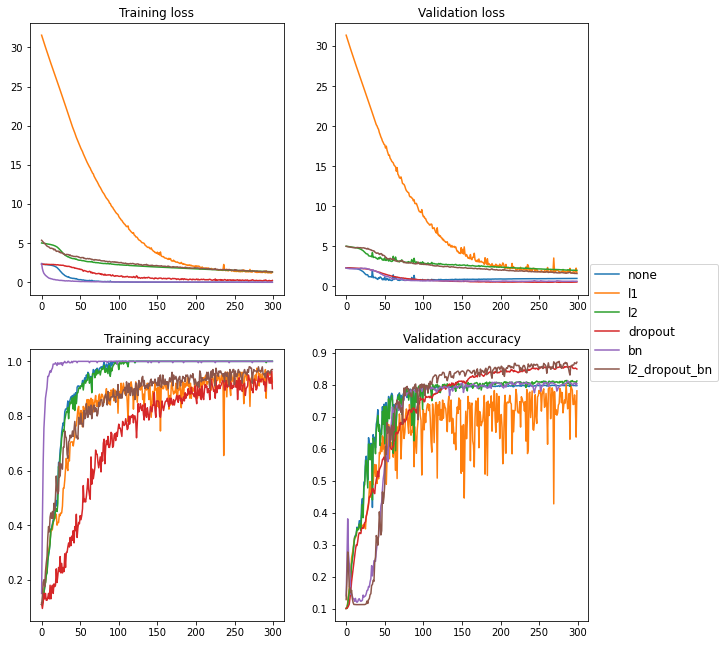

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(11, 11))
axs[0, 0].set_title('Training loss')
axs[0, 1].set_title('Validation loss')
axs[1, 0].set_title('Training accuracy')
axs[1, 1].set_title('Validation accuracy')

lines, labels = [], []
for config_name in history_per_config:
  history = history_per_config[config_name].history
  axs[0, 0].plot(history['loss'])
  axs[0, 1].plot(history['val_loss'])
  axs[1, 0].plot(history['accuracy'])
  line = axs[1, 1].plot(history['val_accuracy'])
  lines.append(line[0])
  labels.append(config_name)

fig.legend(lines, labels, loc='center right', fontsize='large', borderaxespad=0.5)
plt.subplots_adjust(right=.83)

In [28]:
for config_name in history_per_config:
  max_val_acc = max(history_per_config[config_name].history['val_accuracy']) * 100
  print('Max validation accuracy of {0}: {1:.2f}%'.format(config_name, max_val_acc))

Max validation accuracy of none: 79.97%
Max validation accuracy of l1: 80.29%
Max validation accuracy of l2: 81.44%
Max validation accuracy of dropout: 85.84%
Max validation accuracy of bn: 81.22%
Max validation accuracy of l2_dropout_bn: 87.38%
